In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [ ]:
df_AI = pd.read_csv(r"../Rawdat/NS_site_filtered.csv")
grouped_summary_5 = (
    df_AI.groupby('Filename')  
    .filter(lambda df: len(df) >= 5)  
    .groupby('Filename')  
    .agg(
        Slope_P=('Slope', lambda x: (x > 0).mean()), 
        Mean=('Mean', 'mean'),
        Slope_Mean=('Slope', 'mean'),                  
    )
    .reset_index()  
)

In [ ]:
import geopandas as gpd
df_siteg = gpd.read_file("../Rawdat/ITRDB.shp")
grouped_summary_5["Site_ID"] = grouped_summary_5["Filename"].str.replace(r"\.rwl\.csv$", "", regex=True)
dfslope_5 = pd.merge(grouped_summary_5.loc[:,'Slope_P':],df_siteg.loc[:,['Latitude', 'Longitude','Site_ID','ai_v3','Tree_Speci']])
dfslope_3_N_P = dfslope_5[(dfslope_5['Latitude']>0)]
dfslope_3_N_P = dfslope_3_N_P[(dfslope_3_N_P['ai_v3'] >0)]
mean_num = (
    dfslope_3_N_P
    .groupby(["Latitude", "Longitude"], as_index=False)
    .mean(numeric_only=True)
)

meta = (
    dfslope_3_N_P
    .sort_values(["Latitude", "Longitude"])
    .groupby(["Latitude", "Longitude"], as_index=False)
    .first()  
    [["Latitude", "Longitude", "Tree_Speci", "Site_ID"]]  
)

dfslope_3_N_P_mean = mean_num.merge(meta, on=["Latitude", "Longitude"], how="left")
dfslope_3_N_P_mean.to_csv(r'../Rawdat/site5-56.csv', index=False)
species_summary = (
    dfslope_3_N_P_mean
    .groupby("Tree_Speci")
    .agg(
        n_sites=("Mean", "count"),
        Mean_TGAI=("Mean", "mean"),
        Median_TGAI=("Mean", "median"),
        Mean_Slope=("Slope_Mean", "mean"),
        Median_Slope=("Slope_Mean", "median")
    )
    .reset_index()
)

MIN_N = 1
species_summary = species_summary[species_summary["n_sites"] >= MIN_N]

species_summary

,Tree_Speci,n_sites,Mean_TGAI,Median_TGAI,Mean_Slope,Median_Slope
0,ABLA,15,1.107617,1.067171,0.002638,0.001290
1,ABPN,1,0.915006,0.915006,-0.002493,-0.002493
2,CHNO,1,1.341811,1.341811,0.002820,0.002820
3,CHPN,2,1.024650,1.024650,0.000826,0.000826
4,CHTH,4,1.178642,1.134589,0.000194,0.000725
5,FASY,3,1.237691,1.146958,0.007191,0.007804
6,LAGM,2,1.081491,1.081491,0.005726,0.005726
7,LALY,1,1.178666,1.178666,0.001935,0.001935
8,LASI,2,1.064203,1.064203,0.002212,0.002212
9,PCAB,1,0.893417,0.893417,0.001086,0.001086


C:\Users\MSI\AppData\Local\Temp\ipykernel_53140\2392930199.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\MSI\AppData\Local\Temp\ipykernel_53140\2392930199.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


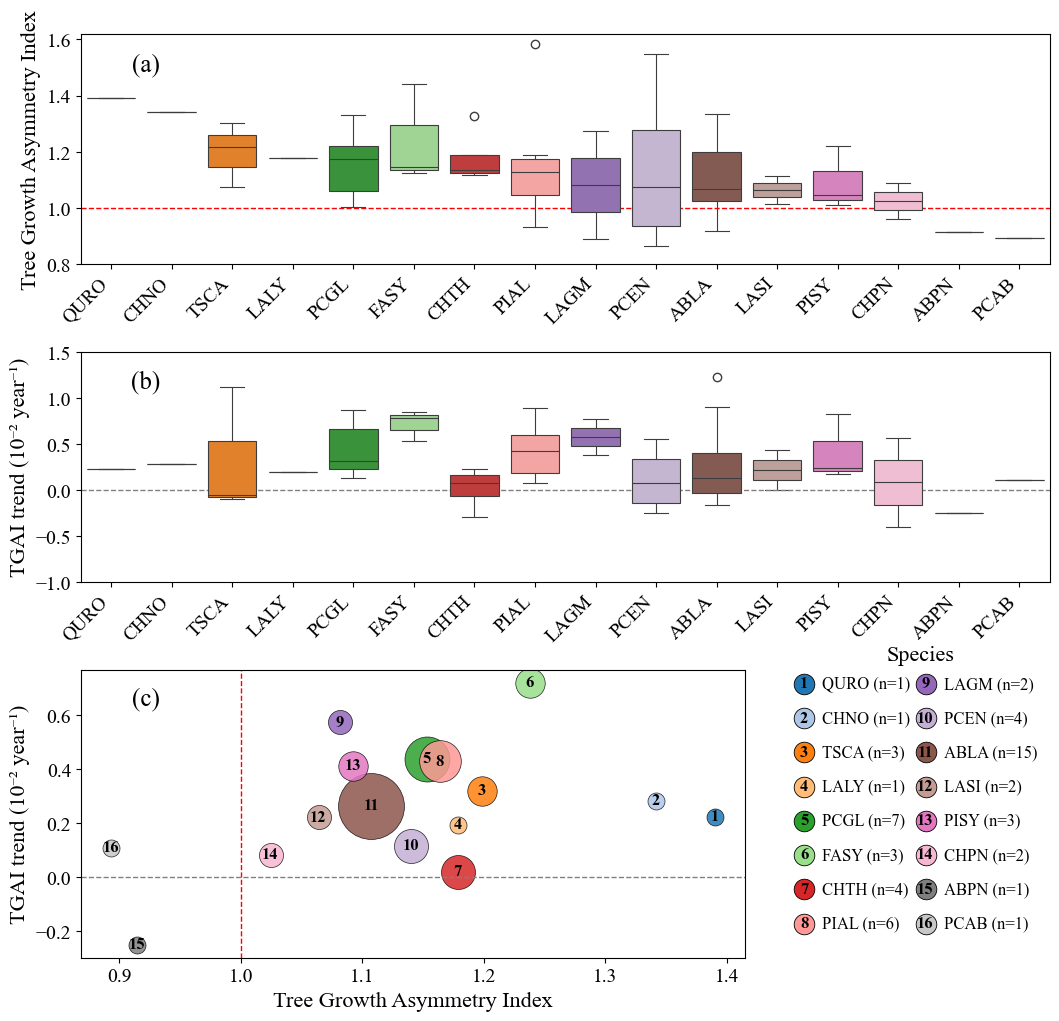

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
df_plot = dfslope_3_N_P_mean[
    dfslope_3_N_P_mean["Tree_Speci"].isin(species_summary["Tree_Speci"])
].copy()
order = (df_plot.groupby("Tree_Speci")["Mean"]
         .median()
         .sort_values(ascending=False)
         .index)
colors = sns.color_palette("tab20", n_colors=len(order))
palette = dict(zip(order, colors))
df_plot2 = df_plot.copy()
df_plot2["Slope_Mean_x100"] = df_plot2["Slope_Mean"] * 100

ss = (
    df_plot2.groupby("Tree_Speci", as_index=False)
    .agg(
        n_sites=("Mean", "count"),
        Mean_TGAI=("Mean", "mean"),
        Mean_Slope_x100=("Slope_Mean_x100", "mean")
    )
)

ss["Tree_Speci"] = pd.Categorical(ss["Tree_Speci"], categories=list(order), ordered=True)
ss = ss.sort_values("Tree_Speci").reset_index(drop=True)
ss["sp_id"] = np.arange(1, len(ss) + 1)

def sig2(x, pos):
    if x == 0 or np.isclose(x, 0):
        return "0"
    return f"{x:.2g}"

fig = plt.figure(figsize=(12.5, 12.0))
gs = fig.add_gridspec(
    3, 2,
    height_ratios=[1.0, 1.0, 1.25],
    width_ratios=[0.72, 0.28],
    hspace=0.35, wspace=0.10
)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, 0])
axL = fig.add_subplot(gs[2, 1])

sns.boxplot(
    data=df_plot,
    x="Tree_Speci", y="Mean",
    order=order,
    palette=palette,
    showfliers=True,
    linewidth=0.8,
    ax=ax1
)
ax1.axhline(1, ls="--", color="red", lw=1)
ax1.set_ylabel("Tree Growth Asymmetry Index")
ax1.yaxis.set_ticks([0.8, 1.0, 1.2, 1.4, 1.6])
ax1.text(-2.5, 3.1, "(a)", transform=axL.transAxes, ha="center", va="center", fontsize=18)
ax1.set_xlabel("")
ax1.tick_params(axis="x", labelrotation=45)
for lbl in ax1.get_xticklabels():
    lbl.set_horizontalalignment("right")


ax1.set_title("")

sns.boxplot(
    data=df_plot2,
    x="Tree_Speci", y="Slope_Mean_x100",
    order=order,
    palette=palette,
    showfliers=True,
    linewidth=0.8,
    ax=ax2
)
ax2.axhline(0, ls="--", color="gray", lw=1)
ax2.set_ylabel("TGAI trend (10⁻² year⁻¹)")
ax2.set_xlabel("")
ax2.yaxis.set_ticks([-1.0, -0.5, 0.0, 0.5, 1.0,1.5])
ax2.tick_params(axis="x", labelrotation=45)
ax2.text(-2.5, 2.0, "(b)", transform=axL.transAxes, ha="center", va="center",fontsize=18)
for lbl in ax2.get_xticklabels():
    lbl.set_horizontalalignment("right")
for _, r in ss.iterrows():
    sp = r["Tree_Speci"]
    if pd.isna(sp):
        continue

    ax3.scatter(
        r["Mean_TGAI"], r["Mean_Slope_x100"],
        s=max(int(r["n_sites"]), 1) * 150,
        color=palette[sp],
        alpha=0.85,
        edgecolor="black",
        linewidth=0.5,
        zorder=2
    )
    ax3.text(
        r["Mean_TGAI"], r["Mean_Slope_x100"],
        str(int(r["sp_id"])),
        ha="center", va="center",
        fontsize=12, fontweight="bold",
        zorder=3
    )

ax3.axvline(1, color="red", ls="--", lw=1)
ax3.axhline(0, color="gray", ls="--", lw=1)
ax3.set_xlabel("Tree Growth Asymmetry Index")
ax3.set_ylabel("TGAI trend (10⁻² year⁻¹)")

ax3.text(-2.5, 0.9, "(c)", transform=axL.transAxes, ha="center", va="center",fontsize=18)
axL.axis("off")
items = []
for _, r in ss.iterrows():
    sp = r["Tree_Speci"]
    if pd.isna(sp):
        continue
    items.append((int(r["sp_id"]), sp, int(r["n_sites"]), palette[sp]))

ncol = 2
n = len(items)
nrow = int(np.ceil(n / ncol))

x_cols = [0.05, 0.52]
y0 = 0.95
dy = 0.95 / max(nrow, 1)
circle_size = 220
fs_id = 12
fs_text = 12

for i, (sid, sp, nn, col) in enumerate(items):
    c = i // nrow
    rr = i % nrow
    x = x_cols[c]
    y = y0 - rr * dy

    axL.scatter(
        x, y,
        s=circle_size,
        color=col,
        edgecolor="black",
        linewidth=0.6,
        transform=axL.transAxes,
        zorder=2
    )
    axL.text(
        x, y, str(sid),
        transform=axL.transAxes,
        ha="center", va="center",
        fontsize=fs_id,
        fontweight="bold",
        color="black",
        zorder=3
    )
    axL.text(
        x + 0.07, y,
        f"{sp} (n={nn})",
        transform=axL.transAxes,
        ha="left", va="center",
        fontsize=fs_text
    )
axL.text(0.5, 1.05, "Species", transform=axL.transAxes, ha="center", va="center")
# plt.savefig(r'../Rawdata/FigS....jpg', dpi=600, bbox_inches='tight')
plt.show()


C:\Users\MSI\AppData\Local\Temp\ipykernel_53140\2785905833.py:45: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


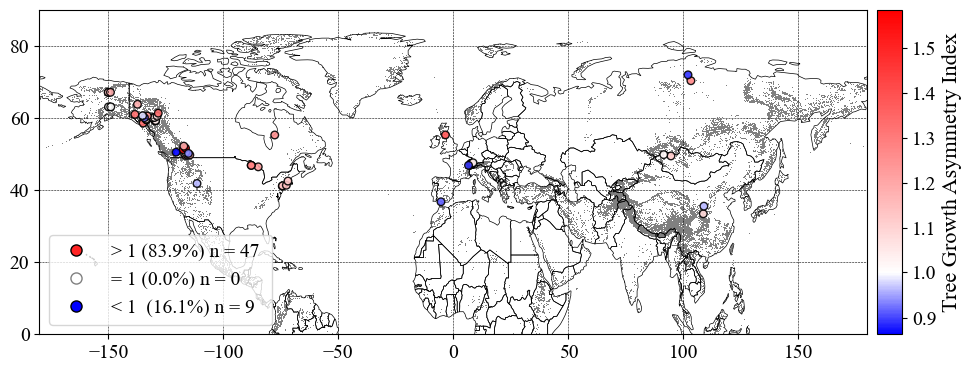

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import numpy as np
from matplotlib.lines import Line2D
import rasterio
from rasterio.plot import show
from matplotlib.colors import ListedColormap

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

tif_path = r"../Rawdat/GMBA_2021_MntnMask_EarthEnv_30s1Bit.tif"

with rasterio.open(tif_path) as src:
    mountain_mask = src.read(1)
    transform = src.transform
    bounds = src.bounds

extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
mountain_cmap = ListedColormap(['white', 'gray'])

geometry = [Point(xy) for xy in zip(dfslope_3_N_P_mean['Longitude'], dfslope_3_N_P_mean['Latitude'])]
gdf = gpd.GeoDataFrame(dfslope_3_N_P_mean, geometry=geometry, crs='EPSG:4326')
conditions = [
    gdf['Mean'] > 1,
    gdf['Mean'] < 1,
    gdf['Mean'] == 1
]
choices = ['> 1', '< 1', '= 1']
gdf['mean_class'] = np.select(conditions, choices, default='= 1')

gdf_gt = gdf[gdf['mean_class'] == '> 1']
gdf_lt = gdf[gdf['mean_class'] == '< 1']
gdf_eq = gdf[gdf['mean_class'] == '= 1']
total = len(gdf)
p_gt = f"({len(gdf_gt)/total*100:.1f}%) n = {len(gdf_gt)} "
p_lt = f" ({len(gdf_lt)/total*100:.1f}%) n = {len(gdf_lt)}"
p_eq = f"({len(gdf_eq)/total*100:.1f}%) n = {len(gdf_eq)}"
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

vmin = gdf['Mean'].min()
vcenter = 1
vmax = gdf['Mean'].max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = cm.bwr
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(mountain_mask, cmap=mountain_cmap, extent=extent, interpolation='none')
world.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
if not gdf_eq.empty:
    gdf_eq.plot(
        ax=ax,
        facecolor='white',
        edgecolor='gray',
        linewidth=1.2,
        markersize=20,
        label='= 1 ' + p_eq
    )

if not gdf_gt.empty:
    gdf_gt.plot(
        ax=ax,
        column='Mean',
        cmap=cmap,
        norm=norm,
        markersize=30,
        edgecolor='k',
        alpha=0.9
    )

if not gdf_lt.empty:
    gdf_lt.plot(
        ax=ax,
        column='Mean',
        cmap=cmap,
        norm=norm,
        markersize=30,
        edgecolor='k',
        alpha=0.9
    )

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, cax=cax)
cb.set_label("Tree Growth Asymmetry Index")
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'> 1 {p_gt}',
           markerfacecolor=cmap(norm(1.5)), markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'= 1 {p_eq}',
           markerfacecolor='white', markeredgecolor='gray', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'< 1 {p_lt}',
           markerfacecolor=cmap(norm(0.8)), markeredgecolor='k', markersize=8),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=14, frameon=True)
ax.set_xlim(-180, 180)
ax.set_ylim(0, 90)
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
ax.set_aspect('auto')
ax.grid(True, linestyle='--', color='black', linewidth=0.4)
plt.tight_layout()
# plt.savefig(r'../Rawdata/FigS7-A.jpg', dpi=600, bbox_inches='tight')
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_53140\2237318242.py:43: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


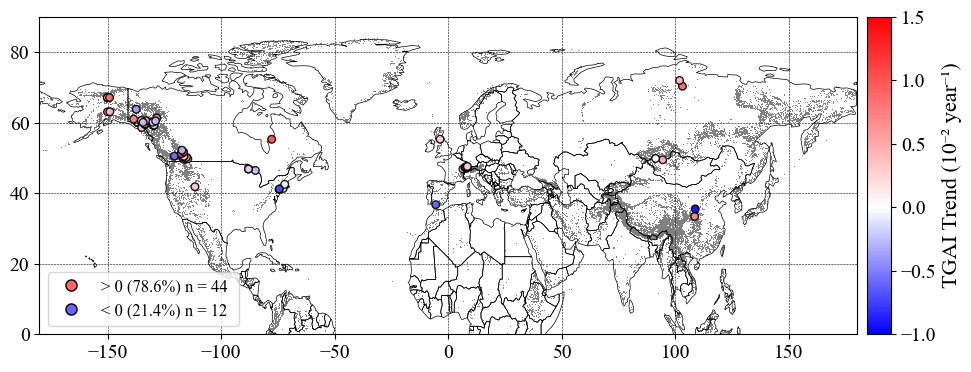

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import numpy as np
from matplotlib.lines import Line2D
import rasterio
from rasterio.plot import show
from matplotlib.colors import ListedColormap
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
tif_path = r"../Rawdat/GMBA_2021_MntnMask_EarthEnv_30s1Bit.tif"

with rasterio.open(tif_path) as src:
    mountain_mask = src.read(1)
    transform = src.transform
    bounds = src.bounds
    raster_crs = src.crs  

extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
mountain_cmap = ListedColormap(['white', 'gray'])
geometry = [Point(xy) for xy in zip(dfslope_3_N_P_mean['Longitude'], dfslope_3_N_P_mean['Latitude'])]
gdf = gpd.GeoDataFrame(dfslope_3_N_P_mean, geometry=geometry, crs='EPSG:4326')
if raster_crs != gdf.crs:
    gdf = gdf.to_crs(raster_crs)

conditions = [
    gdf['Slope_Mean'] > 0,
    gdf['Slope_Mean'] < 0
]
choices = ['> 0', '< 0']
gdf['mean_class'] = np.select(conditions, choices, default=np.nan)

gdf_gt = gdf[gdf['mean_class'] == '> 0']
gdf_lt = gdf[gdf['mean_class'] == '< 0']
total = len(gdf_gt) + len(gdf_lt)
p_gt = f"({len(gdf_gt)/total*100:.1f}%) n = {len(gdf_gt)} "
p_lt = f"({len(gdf_lt)/total*100:.1f}%) n = {len(gdf_lt)} "
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

vmin = gdf['Slope_Mean'].min()
vcenter = 0
vmax = gdf['Slope_Mean'].max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = cm.bwr
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(mountain_mask, cmap=mountain_cmap, extent=extent, interpolation='none', zorder=0)
world.to_crs(gdf.crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
if not gdf_gt.empty:
    gdf_gt.plot(
        ax=ax, column='Slope_Mean', cmap=cmap, norm=norm,
        markersize=30, edgecolor='k', alpha=0.9, zorder=3
    )

if not gdf_lt.empty:
    gdf_lt.plot(
        ax=ax, column='Slope_Mean', cmap=cmap, norm=norm,
        markersize=30, edgecolor='k', alpha=0.9, zorder=3
    )
vmin = -1.0
vmax = 1.5
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = cm.bwr
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cb = plt.colorbar(sm, cax=cax)
cb.set_ticks([-1.0, -0.5, 0, 0.5, 1.0, 1.5])
cb.set_label("TGAI Trend (10⁻² year⁻¹)", fontsize=16)
cb.ax.tick_params(labelsize=14)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'> 0 {p_gt}',
           markerfacecolor=cmap(norm(vmax*0.6)), markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'< 0 {p_lt}',
           markerfacecolor=cmap(norm(vmin*0.6)), markeredgecolor='k', markersize=8),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=12, frameon=True)
ax.set_xlim(-180, 180)
ax.set_ylim(0, 90)
ax.set_aspect('auto')
ax.grid(True, linestyle='--', color='black', linewidth=0.4)

plt.tight_layout()
# plt.savefig(r'../Rawdata/FigS8-A.jpg', dpi=600, bbox_inches='tight')
plt.show()


C:\Users\MSI\AppData\Local\Temp\ipykernel_53140\1492277837.py:41: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


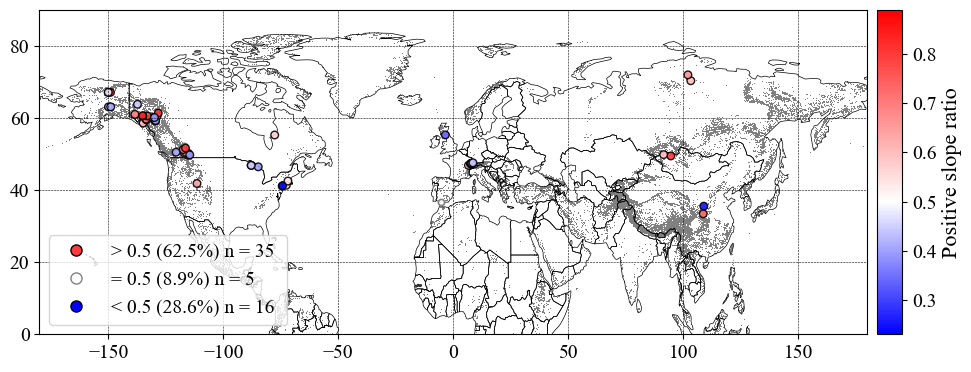

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import numpy as np
from matplotlib.lines import Line2D
import rasterio
from rasterio.plot import show
from matplotlib.colors import ListedColormap
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
tif_path = r"../Rawdat/GMBA_2021_MntnMask_EarthEnv_30s1Bit.tif"

with rasterio.open(tif_path) as src:
    mountain_mask = src.read(1)
    transform = src.transform
    bounds = src.bounds

extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
mountain_cmap = ListedColormap(['white', 'gray'])
geometry = [Point(xy) for xy in zip(dfslope_3_N_P_mean['Longitude'], dfslope_3_N_P_mean['Latitude'])]
gdf = gpd.GeoDataFrame(dfslope_3_N_P_mean, geometry=geometry, crs='EPSG:4326')
conditions = [
    gdf['Slope_P'] > 0.5,
    gdf['Slope_P'] < 0.5,
    gdf['Slope_P'] == 0.5
]
choices = ['> 0.5', '< 0.5', '= 0.5']
gdf['mean_class'] = np.select(conditions, choices, default='= 0.5')
gdf_gt = gdf[gdf['mean_class'] == '> 0.5']
gdf_lt = gdf[gdf['mean_class'] == '< 0.5']
gdf_eq = gdf[gdf['mean_class'] == '= 0.5']
total = len(gdf)
p_gt = f"({len(gdf_gt)/total*100:.1f}%) n = {len(gdf_gt)} "
p_lt = f"({len(gdf_lt)/total*100:.1f}%) n = {len(gdf_lt)}"
p_eq = f"({len(gdf_eq)/total*100:.1f}%) n = {len(gdf_eq)}"
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
vmin = gdf['Slope_P'].min()
vcenter = 0.5
vmax = gdf['Slope_P'].max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = cm.bwr
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(mountain_mask, cmap=mountain_cmap, extent=extent, interpolation='none')
world.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
if not gdf_eq.empty:
    gdf_eq.plot(
        ax=ax,
        facecolor='white',
        edgecolor='gray',
        linewidth=1.2,
        markersize=20,
        label='= 1 ' + p_eq
    )

if not gdf_gt.empty:
    gdf_gt.plot(
        ax=ax,
        column='Slope_P',
        cmap=cmap,
        norm=norm,
        markersize=30,
        edgecolor='k',
        alpha=0.9
    )

if not gdf_lt.empty:
    gdf_lt.plot(
        ax=ax,
        column='Slope_P',
        cmap=cmap,
        norm=norm,
        markersize=30,
        edgecolor='k',
        alpha=0.9
    )

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, cax=cax)
cb.set_label("Positive slope ratio")
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'> 0.5 {p_gt}',
           markerfacecolor=cmap(norm(0.8)), markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'= 0.5 {p_eq}',
           markerfacecolor='white', markeredgecolor='gray', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'< 0.5 {p_lt}',
           markerfacecolor=cmap(norm(0.2)), markeredgecolor='k', markersize=8),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=14, frameon=True)
ax.set_xlim(-180, 180)
ax.set_ylim(0, 90)
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
ax.set_aspect('auto')
ax.grid(True, linestyle='--', color='black', linewidth=0.4)

plt.tight_layout()
# plt.savefig(r'../Rawdata/FigS9-B.jpg', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
if not hasattr(np, "alen"):
    np.alen = lambda a: len(a)
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np
pre_path = r"../Rawdat/cru_ts4.07.1901.2022.pre.dat.nc"
tmp_path = r"../Rawdat/cru_ts4.07.1901.2022.tmp.dat.nc"
gdf = gdf.copy()
if 'Longitude' not in gdf.columns or 'Latitude' not in gdf.columns:
    gdf['Longitude'] = gdf.geometry.x
    gdf['Latitude'] = gdf.geometry.y
ds_pre = xr.open_dataset(pre_path)
ds_tmp = xr.open_dataset(tmp_path)
gs_months = np.arange(3, 11)
pre = ds_pre['pre']  # mm/month
pre_gs = pre.where(pre['time'].dt.month.isin(gs_months), drop=True)
pre_gs_annual = pre_gs.groupby('time.year').sum(dim='time')
pre_gs_clim = pre_gs_annual.mean(dim='year')
tmp = ds_tmp['tmp']  # °C
tmp_gs = tmp.where(tmp['time'].dt.month.isin(gs_months), drop=True)
tmp_gs_annual = tmp_gs.groupby('time.year').mean(dim='time')
tmp_gs_clim = tmp_gs_annual.mean(dim='year')
lon_points = xr.DataArray(gdf['Longitude'].values, dims=('points',))
lat_points = xr.DataArray(gdf['Latitude'].values, dims=('points',))
pre_gs_vals = pre_gs_clim.interp(lon=lon_points, lat=lat_points, method='linear').values
tmp_gs_vals = tmp_gs_clim.interp(lon=lon_points, lat=lat_points, method='linear').values
gdf['Pre_GS'] = pre_gs_vals       
gdf['Tmp_GS'] = tmp_gs_vals    
print(gdf[['Longitude', 'Latitude', 'Pre_GS', 'Tmp_GS']].head())
df_meanC = gdf.dropna(subset=['Pre_GS', 'Tmp_GS', 'Mean']).copy()


    Longitude   Latitude      Pre_GS     Tmp_GS
0  108.654847  33.440325  828.096378  15.438782
1  108.905503  35.554255  568.098834  15.124842
2   -5.415830  36.768000  350.324473  18.318755
3  -74.420000  41.115000  852.108122  14.886940
4  -74.326000  41.206000  849.943083  14.772387


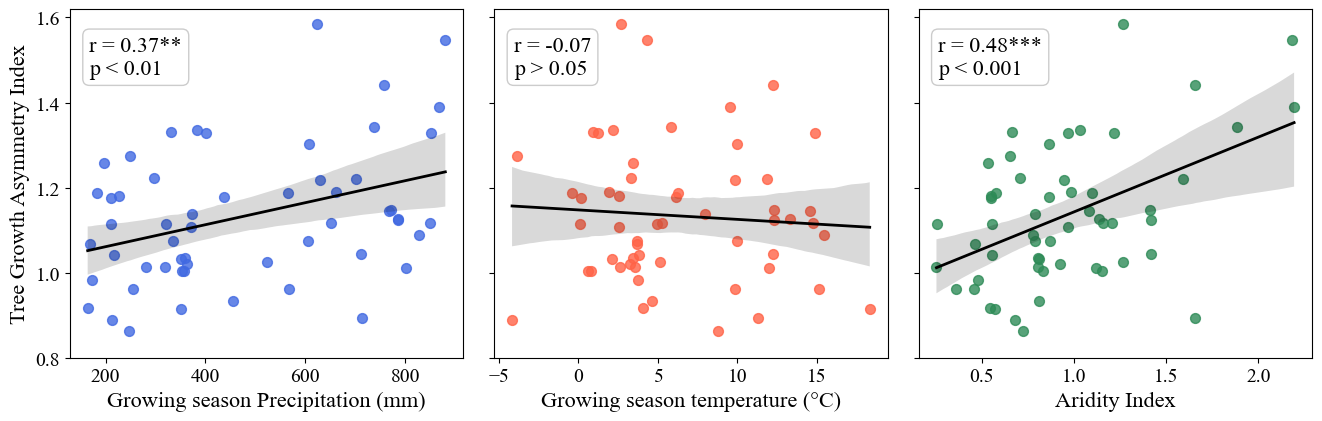

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
variables = [
    ('Pre_GS', 'Growing season Precipitation (mm)', 'royalblue'),
    ('Tmp_GS', 'Growing season temperature (°C)', 'tomato'),
    ('ai_v3', 'Aridity Index', 'seagreen')
]
# y_limits = (0.7, 1.6)
y_ticks = [0.8, 1.0, 1.2, 1.4, 1.6]

fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5), sharey=True)

for ax, (var, xlabel, color) in zip(axes, variables):
    x = df_meanC[var]
    y = df_meanC['Mean']

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    if p_value < 0.001:
        signif = '***'
        p_label = 'p < 0.001'
    elif p_value < 0.01:
        signif = '**'
        p_label = 'p < 0.01'
    elif p_value < 0.05:
        signif = '*'
        p_label = 'p < 0.05'
    else:
        signif = ''
        p_label = 'p > 0.05'

    r_text = f"r = {r_value:.2f}{signif}\n{p_label}"

    sns.regplot(
        x=x, y=y, ax=ax,
        scatter_kws={'alpha': 0.8, 'color': color, 's': 50},
        line_kws={'color': 'black', 'lw': 2},
        ci=95
    )

    ax.set_xlabel(xlabel)
    # ax.set_ylim(*y_limits)
    ax.set_yticks(y_ticks)
    
    if ax == axes[0]:
        ax.set_ylabel('Tree Growth Asymmetry Index')
    else:
        ax.set_ylabel('')

    ax.text(
        0.05, 0.80, r_text,
        transform=ax.transAxes,
        verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.4)
    )

plt.tight_layout()
# plt.savefig(r'../Rawdata/FigS7-CDE.jpg', dpi=600, bbox_inches='tight')
plt.show()


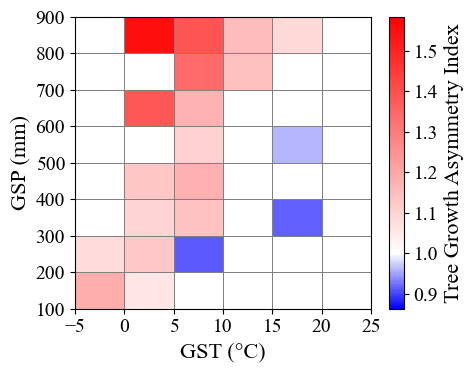

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

temp_bins = np.arange(-5, 30, 5)      # -10, -6, ..., 18
prec_bins = np.arange(100, 1000, 100)  # 200, 400, ..., 2000

df_meanC['temp_bin'] = pd.cut(df_meanC['Tmp_GS'], bins=temp_bins, include_lowest=True, right=False)
df_meanC['prec_bin'] = pd.cut(df_meanC['Pre_GS'], bins=prec_bins, include_lowest=True, right=False)

pivot_table = df_meanC.pivot_table(values='Mean', index='prec_bin', columns='temp_bin', aggfunc='mean')

temp_index = pd.IntervalIndex.from_breaks(temp_bins, closed='left')
prec_index = pd.IntervalIndex.from_breaks(prec_bins, closed='left')
pivot_table = pivot_table.reindex(index=prec_index, columns=temp_index)

z = pivot_table.to_numpy()

x_edges = temp_bins
y_edges = prec_bins

assert z.shape == (len(y_edges) - 1, len(x_edges) - 1)

fig, ax = plt.subplots(figsize=(5, 4))

norm = mcolors.TwoSlopeNorm(vmin=df_meanC['Mean'].min(), vcenter=1.0, vmax=df_meanC['Mean'].max())
cmap = plt.get_cmap('bwr')

mesh = ax.pcolormesh(x_edges, y_edges, z,
                     cmap=cmap, norm=norm,
                     edgecolors='gray', linewidth=0.5)


ax.set_xticks(temp_bins)
ax.set_yticks(prec_bins)

ax.set_xlabel("GST (°C)", fontsize=16)
ax.set_ylabel("GSP (mm)", fontsize=16)
ax.tick_params(labelsize=14)

cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label("Tree Growth Asymmetry Index", fontsize=16)

plt.tight_layout()
# plt.savefig(r'../Rawdata/FigS7-B.jpg', dpi=600, bbox_inches='tight')
plt.show()


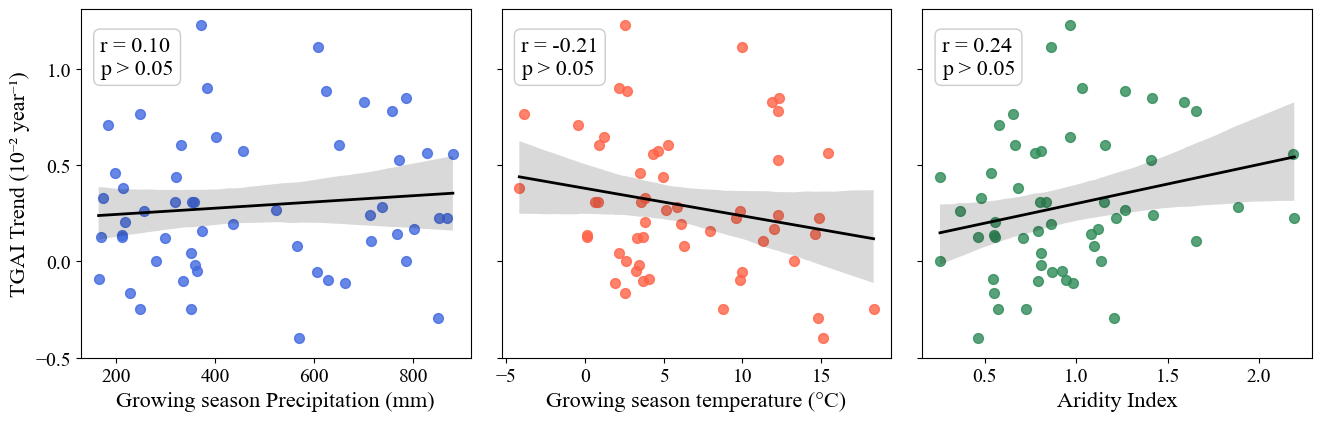

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

variables = [
    ('Pre_GS', 'Growing season Precipitation (mm)', 'royalblue'),
    ('Tmp_GS', 'Growing season temperature (°C)', 'tomato'),
    ('ai_v3', 'Aridity Index', 'seagreen')
]

# y_limits = (0.7, 1.6)
y_ticks = [ -0.5, 0, 0.5, 1.0]
y_label = "TGAI Trend (10⁻² year⁻¹)"


fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5), sharey=True)

for ax, (var, xlabel, color) in zip(axes, variables):
    x = df_meanC[var]
    y = df_meanC['Slope_Mean']* 100


    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    if p_value < 0.001:
        signif = '***'
        p_label = 'p < 0.001'
    elif p_value < 0.01:
        signif = '**'
        p_label = 'p < 0.01'
    elif p_value < 0.05:
        signif = '*'
        p_label = 'p < 0.05'
    else:
        signif = ''
        p_label = 'p > 0.05'

    r_text = f"r = {r_value:.2f}{signif}\n{p_label}"

    sns.regplot(
        x=x, y=y, ax=ax,
        scatter_kws={'alpha': 0.8, 'color': color, 's': 50},
        line_kws={'color': 'black', 'lw': 2},
        ci=95
    )

    ax.set_xlabel(xlabel)
    # ax.set_ylim(*y_limits)
    ax.set_yticks(y_ticks)
    
    if ax == axes[0]:
        ax.set_ylabel(y_label)
    else:
        ax.set_ylabel('')

    ax.text(
        0.05, 0.80, r_text,
        transform=ax.transAxes,
        verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.4)
    )

plt.tight_layout()
# plt.savefig(r'../Rawdata/FigS8-CDE.jpg', dpi=600, bbox_inches='tight')
plt.show()

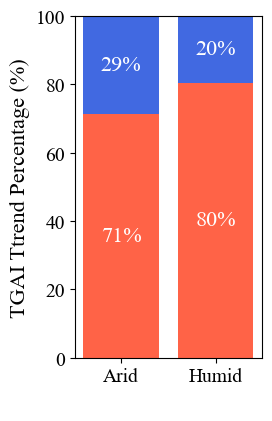

In [ ]:
df_meanC['climate_zone'] = np.where(df_meanC['ai_v3'] < 0.65, 'Arid', 'Humid')

def calc_positive_slope_ratio(group):
    total = len(group)
    positive = (group['Slope_Mean'] > 0).sum()
    return round(positive / total, 3) if total > 0 else np.nan
slope_ratio = df_meanC.groupby('climate_zone').apply(calc_positive_slope_ratio).rename('Positive_Slope_Ratio')

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
df_meanC['Trend'] = df_meanC['Slope_Mean'].apply(lambda x: 'Increasing' if x > 0 else 'Decreasing')

df_percent = (
    df_meanC.groupby(['climate_zone', 'Trend'])
       .size()
       .reset_index(name='Count')
       .pivot(index='climate_zone', columns='Trend', values='Count')
       .fillna(0)
)

df_percent['Total'] = df_percent.sum(axis=1)
df_percent['Increasing_%'] = df_percent['Increasing'] / df_percent['Total'] * 100
df_percent['Decreasing_%'] = df_percent['Decreasing'] / df_percent['Total'] * 100

fig, ax = plt.subplots(figsize=(3, 4.5))
climate_zones = df_percent.index.tolist()
increasing = df_percent['Increasing_%'].values
decreasing = df_percent['Decreasing_%'].values

ax.bar(climate_zones, increasing, label='Increasing', color='tomato')
ax.bar(climate_zones, decreasing, bottom=increasing, label='Decreasing', color='royalblue')

ax.set_ylabel('TGAI Ttrend Percentage (%)', fontsize=16)
ax.set_xlabel(' ')
ax.set_ylim(0, 100)


for i, (inc, dec) in enumerate(zip(increasing, decreasing)):
    ax.text(i, inc / 2, f'{inc:.0f}%', ha='center', va='center', color='white', fontsize=16)
    ax.text(i, inc + dec / 2, f'{dec:.0f}%', ha='center', va='center', color='white', fontsize=16)

plt.tight_layout()
# plt.savefig(r'../Rawdata/FigS8-B.jpg', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
dfslope_3_N_P_mean.columns =['Latitude', 'Longitude', 'Slope_P', 'Mean', 'Slope_Mean', 'AI',
       'Tree_Speci', 'site']
import os
import pandas as pd
import numpy as np
folder = r"../Rawdat/rwl_files"
target_sites = dfslope_3_N_P_mean['site'].str.upper().unique()
prefix_filter = set(df_AI['Prefix'].unique()) 

records = []

for site in target_sites:
    filename = site + ".rwl.csv"
    filepath = os.path.join(folder, filename)

    if not os.path.exists(filepath):
        print(f"⚠️ ：{filename}")
        continue

    try:
        df = pd.read_csv(filepath, index_col=0)
        df.index = df.index.astype(int)
        df.columns = [col.upper() for col in df.columns]
        df = df[(df.index >= 1901) & (df.index <= 2015)]
    except Exception as e:
        print(f"❌ {filename}：{e}")
        continue

    all_cols = df.columns.tolist()

    for col in all_cols:
        if col.endswith("N"):
            prefix = col[:-1]
            if prefix not in prefix_filter:
                continue

            col_n = col
            col_s = prefix + "S"
            if col_s in all_cols:
                s_vals = df[col_s]
                n_vals = df[col_n]
                sn_ratio = s_vals / n_vals
                sn_ratio = sn_ratio.replace([np.inf, -np.inf], np.nan).dropna()

                df_ratio = pd.DataFrame({
                    "Year": sn_ratio.index,
                    "Prefix": prefix,
                    "site": site,
                    "SN_Ratio": sn_ratio.values
                })
                records.append(df_ratio)


if records:
    df_all_sn = pd.concat(records, ignore_index=True)
else:
    print("⚠️ ")
lower_bound = df_all_sn['SN_Ratio'].quantile(0.01)  
upper_bound = df_all_sn['SN_Ratio'].quantile(0.99)  
df_filtered = df_all_sn[(df_all_sn['SN_Ratio'] >= lower_bound) & (df_all_sn['SN_Ratio'] <= upper_bound)]
dfslope_3_N_P_mean['site'] = dfslope_3_N_P_mean['site'].str.strip().str.lower()
df_filtered['site'] = df_filtered['site'].str.strip().str.lower()
df_filtered = df_filtered.merge(
    dfslope_3_N_P_mean[['site', 'AI']],
    on='site',
    how='left'  
)
df_filtered['climate_zone'] = df_filtered['AI'].apply(
    lambda x: 'arid' if x < 0.65 else 'humid'
)


C:\Users\MSI\AppData\Local\Temp\ipykernel_53140\2151627409.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['site'] = df_filtered['site'].str.strip().str.lower()


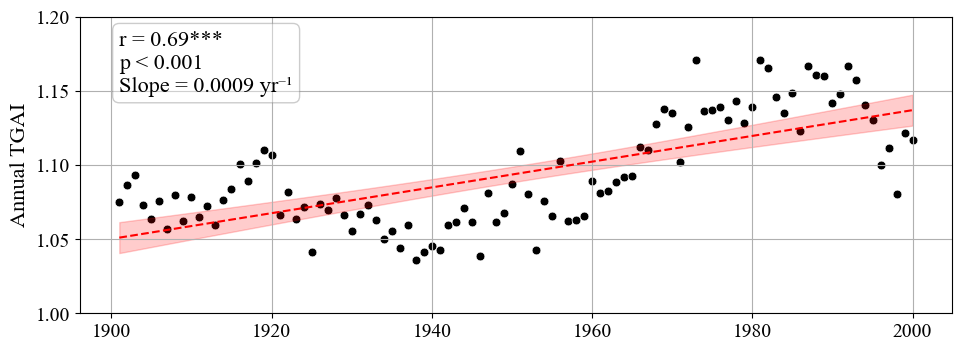

In [ ]:
df_filtered_2000 = df_filtered[df_filtered['Year']<=2000]
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import numpy as np
import statsmodels.api as sm


plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14


df_grouped = df_filtered_2000.groupby('Year')['SN_Ratio'].mean().reset_index()
x = df_grouped['Year']
y = df_grouped['SN_Ratio']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
pred = model.get_prediction(X)
ci = pred.conf_int()
mean_pred = pred.predicted_mean


if p_value < 0.001:
    signif = '***'
    p_label = 'p < 0.001'
elif p_value < 0.01:
    signif = '**'
    p_label = 'p < 0.01'
elif p_value < 0.05:
    signif = '*'
    p_label = 'p < 0.05'
else:
    signif = ''
    p_label = 'p ≥ 0.05'


textstr = '\n'.join((
    f'r = {r_value:.2f}{signif}',
    f'{p_label}',
    f'Slope = {slope:.4f} yr⁻¹'
))


plt.figure(figsize=(10, 4))
sns.scatterplot(x=x, y=y, color='black', s=40)


plt.plot(x, mean_pred, color='red', linestyle='--', label='Linear Fit')
plt.fill_between(x, ci[:, 0], ci[:, 1], color='red', alpha=0.2, label='95% CI')


plt.text(x.min(), y.max()+0.02, textstr,
         verticalalignment='top',
         fontsize=16,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.4))


plt.xlabel("")
plt.ylabel("Annual TGAI")
plt.tight_layout()
plt.yticks([1.0,1.05, 1.1,1.15, 1.2])
# plt.ylim(0.95,1.25)
plt.grid(True)

# plt.savefig(r'../Rawdata/FigS9-A.jpg', dpi=600, bbox_inches='tight')
plt.show()



=== ANCOVA  ===
                  sum_sq     df           F        PR(>F)
C(Region)       0.053956    1.0   55.517572  2.892656e-12
Year            0.125472    1.0  129.102543  2.603939e-23
Year:C(Region)  0.000086    1.0    0.088934  7.658530e-01
Residual        0.190488  196.0         NaN           NaN


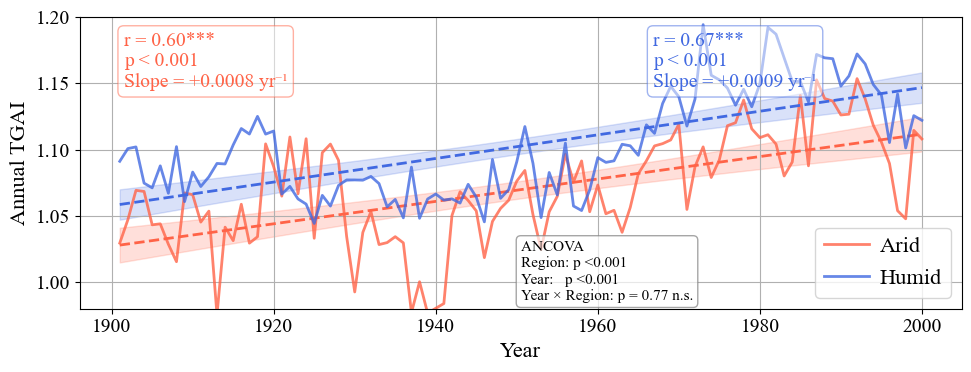

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# =========================
# Identify sites that still have observational data after 2010.

df_filtered_2000 = df_filtered[df_filtered['Year']<=2000]

df_arid = df_filtered_2000[df_filtered_2000['AI'] < 0.65]
df_humid = df_filtered_2000[df_filtered_2000['AI'] >= 0.65]


df_arid_grouped = df_arid.groupby('Year')['SN_Ratio'].mean().reset_index()
df_humid_grouped = df_humid.groupby('Year')['SN_Ratio'].mean().reset_index()

# =========================
plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14


df_arid = df_filtered_2000[df_filtered_2000['AI'] < 0.65].copy()
df_humid = df_filtered_2000[df_filtered_2000['AI'] >= 0.65].copy()


df_arid_grouped = (
    df_arid.groupby('Year', as_index=False)['SN_Ratio']
           .mean()
)
df_humid_grouped = (
    df_humid.groupby('Year', as_index=False)['SN_Ratio']
            .mean()
)

df_arid_grouped['Region'] = 'Arid'
df_humid_grouped['Region'] = 'Humid'
df_all = pd.concat([df_arid_grouped, df_humid_grouped], ignore_index=True)
model = ols("SN_Ratio ~ Year * C(Region)", data=df_all).fit()
ancova_res = anova_lm(model, typ=2)

print("\n=== ANCOVA  ===")
print(ancova_res)

p_region = ancova_res.loc["C(Region)", "PR(>F)"]
p_year = ancova_res.loc["Year", "PR(>F)"]
p_inter = ancova_res.loc["Year:C(Region)", "PR(>F)"]

def signif_star(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "n.s."

ancova_text = (
    "ANCOVA \n"
    f"Region: p <0.001 \n"
    f"Year:   p <0.001\n"
    f"Year × Region: p = {p_inter:.2g} {signif_star(p_inter)}"
)

# =========================
# Plotting: Two broken lines + fitted line + regression line 95% CI
# =========================
fig, ax = plt.subplots(figsize=(10, 4))

def plot_line_with_trend(data, color, label, xpos, ax):

    data = data.sort_values('Year')
    x = data['Year'].values
    y = data['SN_Ratio'].values


    ax.plot(x, y, '-', color=color, alpha=0.8, label=label, linewidth=2)


    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    y_pred = intercept + slope * x
    ax.plot(x, y_pred, color=color, linestyle='--', linewidth=2)


    n = len(x)
    t_val = stats.t.ppf(0.975, df=n - 2)  
    s_err = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
    x_mean = np.mean(x)
    sxx = np.sum((x - x_mean) ** 2)
    conf = t_val * s_err * np.sqrt(1.0 / n + (x - x_mean) ** 2 / sxx)
    lower = y_pred - conf
    upper = y_pred + conf
    ax.fill_between(x, lower, upper, color=color, alpha=0.2)


    if p_value < 0.001:
        signif = '***'
        p_label = 'p < 0.001'
    elif p_value < 0.01:
        signif = '**'
        p_label = 'p < 0.01'
    elif p_value < 0.05:
        signif = '*'
        p_label = 'p < 0.05'
    else:
        signif = ''
        p_label = 'p ≥ 0.05'


    textstr = f"r = {r_value:.2f}{signif}\n{p_label}\nSlope = {slope:+.4f} yr⁻¹"
    ax.text(
        xpos, 0.95, textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='top',
        color=color,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.5)
    )


plot_line_with_trend(
    df_arid_grouped[['Year', 'SN_Ratio']], 
    color='tomato', label='Arid', xpos=0.05, ax=ax
)


plot_line_with_trend(
    df_humid_grouped[['Year', 'SN_Ratio']], 
    color='royalblue', label='Humid', xpos=0.65, ax=ax
)


ax.text(
    0.5, 0.02, ancova_text,
    transform=ax.transAxes,
    fontsize=11,
    va='bottom', ha='left',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
)


ax.set_xlabel('Year')
ax.set_ylabel('Annual TGAI')
ax.legend(
    loc='lower right', frameon=True, ncol=1,
    handletextpad=0.5, columnspacing=1.0
)
ax.grid(True)
ax.set_ylim(0.98, 1.2)
# ax.set_yticks([ 0.9, 1.0, 1.1, 1.2])
plt.tight_layout()
# plt.savefig(r'../Rawdata/FigS9-B.jpg', dpi=600, bbox_inches='tight')
plt.show()
